In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from Kildekode._12_IIRFilt import *
from Kildekode._14_Z_transformasjon import *

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Sample Rate Conversion

* **Emne AIS2201 - Signalbehandling**
* **Uke 46, 2024**
* **Underviser: Kai Erik Hoff**

# What is sample rate conversion?

* Process of changing the sample rate of a discrete-time signal.

<img src="figures/sample_rate_conversion/sample_rate_conversion.png" align="center" style="width: 60%; margin-left:100px">

* **Goal:** *"Transform one digital stream of sampled data $x_{\text{old}}[n]$ sampled with sampling frequency $f_{s, \text{ old}}$ into a new signal $x_{\text{new}}[m]$ using sampling frequency $f_{s, \text{ new}}$, without compromising the spectral content of the signal."*

## Recap: Nyquist Sampling Theorem

* An analog signal $x(t)$ which does not contain frequency components of a frequency greater than $f_{\max}$ may represented in it´s entirety by a digital signal $x[n] = x(n\cdot T_s)$, provided the sampling frequency $f_s =\frac{1}{T_s}$ is greater than $2\cdot f_{max}$.

## $$f_s > 2\cdot f_{max} = \text{Nyquist rate}$$

* The maximum frequency which may be representeed by the digital signal $x[n]$,  $\frac{f_s}{2}$, is known as the *Nyquist Frequency*.

# Recap: Aliasing
* Aliasing occurse when the sampling theorem is **not** satisfied.

Output()

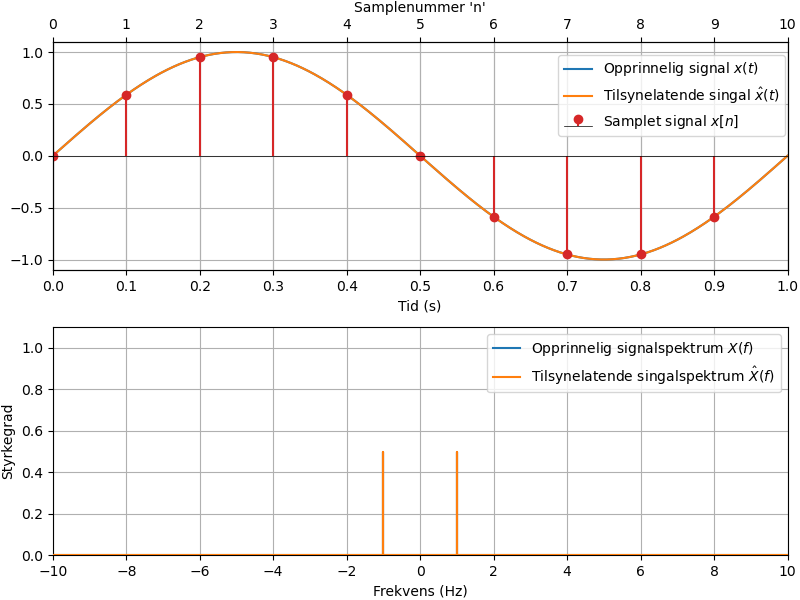

In [2]:
from Kildekode._05_Aliasing import aliasingDemo2
aliasingDemo2(fig_num=3)

# Sampling shown in the frequency domain

* Utvidet representasjon av et digitalt signal i frekvensdomenet gir periodisk frekvensinnhold der perioden er $2\pi$.
* Det båndbegrensede signalet får en serie ***spektrale kopier*** sentrert rundt $\hat{\omega} = k\cdot 2\pi$.
* Alle mulige spektrale kopier av et digitalt signal er "til stede" i signalets frekvensspekter.
    - Fourieranalyse av det digitale signalet vil gi utslag for alle disse kopiene

<img src="Figurer/05_Sampling_og_Aliasing/Fig10_SpectralSamling2.png" style="width: 90%">

# Aliasing in the frequency domain

* Alle disse verlappende frekvenskomponentene kan ha uforutsigbare konsekvenser, og enten kansellere ut hverandre eller legges sammen.
* Rekonstruksjon av opprinnelig signal ikke gjennomførbart.

<img src="Figurer/05_Sampling_og_Aliasing/Fig12_SpectralAliasing2.png" style="width: 90%">

# Anti-aliasing filter
* Vi trenger en måte å gardere mot mulig høyfrekvent signalinnhold utenfor Nyqist-frekvensen.
* Et *analogt* filter i forkant av A/D omformeren kan brukes til å dempe høyfrekvent signalinnhold før sampling.

<img src="Figurer/05_Sampling_og_Aliasing/Fig16_AntiAliasing1.png" style="width: 80%; margin-left: 100px%">

# Part I: *Downsampling*

* Follows much the same rules as A/D conversion
    * A/D converion can be viewed as reducing a signal´s sampling frequency from "infinite" to a finite value $f_s$
    * Downsamling reduces a signal´s sampling frequency from $f_s$ to $\frac{f_s}{M}$

<img src="figures/sample_rate_conversion/downsampling.png" align="center" style="width: 60%; margin-left:100px">

* Performed in $2$ stages: *decimation filter* followed by *decimation*
    1. Decimation filtering commonly performed using a digital FIR filter
        * Serves similar role to an *anti-aliasing filter*
    3. Decimation by an integer factor $M$ will retain only $1$ in $M$ samples

# Decimation example

* Code cell shows an example where a signal $x(t) = \sin(6 \pi \cdot t) + \cos(13\pi \cdot t)$ is sampled at a sampling frequency $f_s = 20$ samples per second, and then decimated by a factor $M=2$.

In [3]:
def decimate(x, M):
    return x[::M]  # x_new[m]

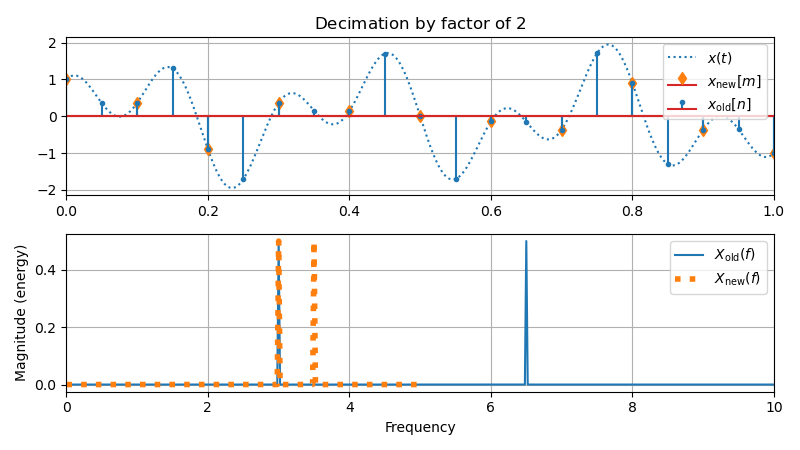

In [4]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
M = 2  # Decimation Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before decimation
t_m = t_n[::M]  # Sample times after decimation

x = lambda t: np.sin(np.pi*6*t) + cos(np.pi*13*t) # The continuous-time signal x(t)
x_n = x(t_n)
x_m = decimate(x_n, M)

plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim(xmax=1)
ax[0].legend()
ax[1].magnitude_spectrum(x(t_n), Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x(t_m), Fs=fs//M, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Decimation by factor of ${M}$");

# Decimation Filter

* Before decimation, frequency components above $\frac{f_{s,\text{ new}}[n]}{2} = \frac{f_{s,\text{ old}}[n]}{2\cdot M}$ need to be suppressed.
* Below is shown an example filter for $M=2$

In [9]:
def design_lowpass(numtaps, # Number of filter taps
                   M):      # Decimation factor
    w_c = pi/M
    n = np.arange(numtaps)-(numtaps-1)/2
    h_n = w_c/pi*np.sinc(w_c/pi*n)*sig.windows.hamming(numtaps)
    return h_n

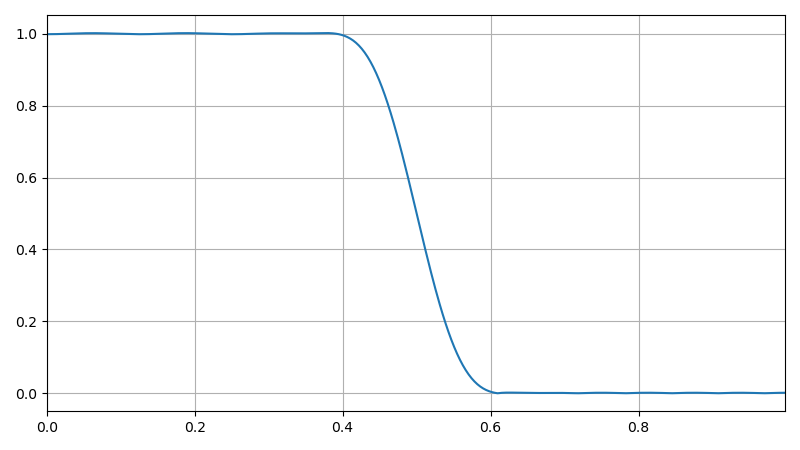

In [10]:
numtaps = 33
M = 2
h_n = design_lowpass(numtaps, M)
w, Hw = sig.freqz(h_n)
plt.figure()
plt.plot(w/np.pi, np.abs(Hw))

## Downsampling example
* Code cell shows an example where a signal $x(t) = \sin(6 \pi \cdot t) + \cos(13\pi \cdot t)$ is sampled at a sampling frequency $f_s = 20$ samples per second, and then resampled to $f_{s, \text{ new}} = \frac{f_{s, \text{ old}}}{2}$.

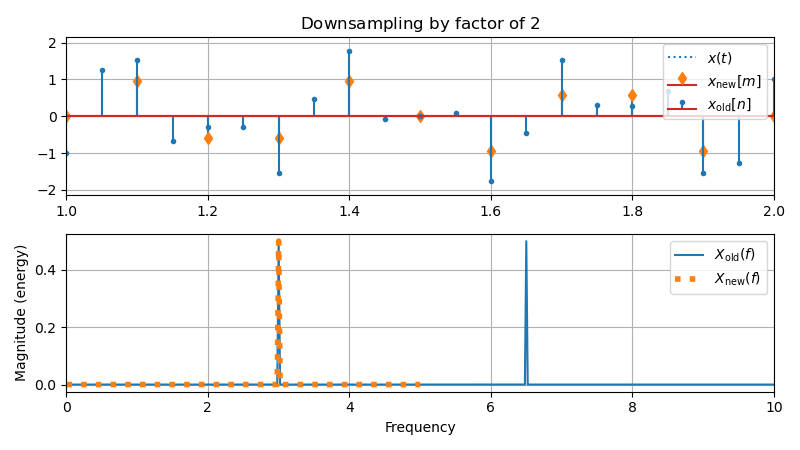

In [13]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
M = 2  # Decimation Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before decimation
t_m = decimate(t_n, M)  # Sample times after decimation

x = lambda t: np.sin(np.pi*6*t) + cos(np.pi*13*t) # The continuous-time signal x(t)

x_n = x(t_n)
x_m = np.convolve(x_n, h_n, mode="same")
x_m = decimate(x_m, M)


plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim([1, 2])
ax[0].legend()
ax[1].magnitude_spectrum(x_n, Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x_m, Fs=fs//M, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Downsampling by factor of ${M}$");

## Downsampling tricks




* Only $1$ in $M$ output samples actually need to be computed

* Can be done in multiple stages to save processing operations

# Part II: *upsampling*

<img src="figures/sample_rate_conversion/upsampling.png" align="center" style="width: 80%; margin-left:100px">

* **Goal:**<br>Given a discrete-time signal $x_{\text{old}}[n]$ which relates to an analog signal $x(t)$ as follows:
$$x_{\text{old}}[n] = x\left(\frac{n}{f_{s, \text{ old}}}\right)$$
"Fill in" $L-1$ sample values between each sample in $x_{\text{old}}[n]$ so that to create a new discrete-time signal $x_{\text{new}}[m]$ so that:
$$\begin{align}x_{\text{new}}[m] &= x\left(\frac{m}{f_{s, \text{ new}}}\right)\\
&= x\left(\frac{m}{L \cdot f_{s, \text{ old}}}\right)\end{align}$$

## Ideal upsampling illustrated

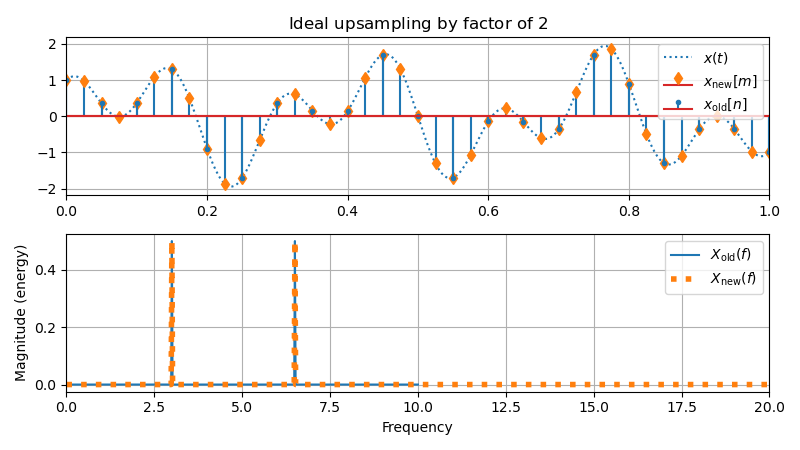

In [15]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
L = 2  # Upsampling Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before upsampling
t_m = np.linspace(0, T, fs*L*T, endpoint=False)  # Sample times after upsampling

x = lambda t: np.sin(np.pi*6*t) + cos(np.pi*13*t) # The continuous-time signal x(t)

plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x(t_m), markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x(t_n), markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim(xmax=1)
ax[0].legend()
ax[1].magnitude_spectrum(x(t_n), Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x(t_m), Fs=fs*L, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Ideal upsampling by factor of ${L}$");

## Upsampling defined in the frequency domain

* The frequency content after upsampling should be:

$$ X_{\text{new}}(\hat{\omega}) = \begin{cases} X_{\text{old}}\left(\hat{\omega}\cdot L\right), & \frac{-\pi}{L} \leq \hat{\omega} \leq  \frac{-\pi}{L} \\ 0, & \text{otherwise} \end{cases}$$

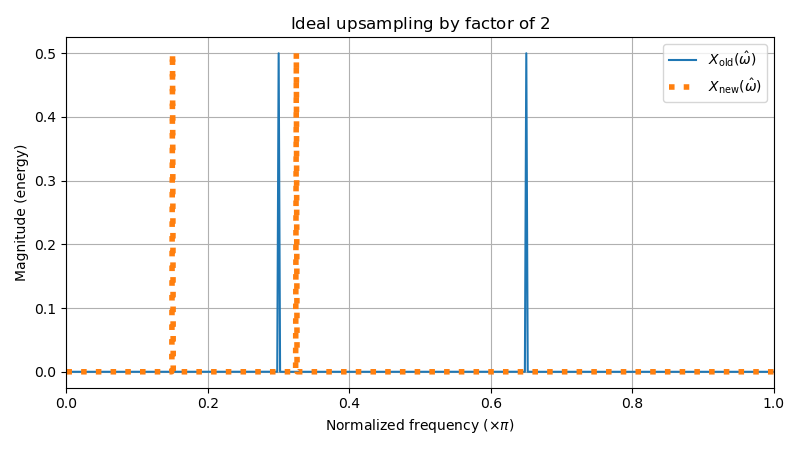

In [17]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
L = 2  # Upsampling Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before upsampling
t_m = np.linspace(0, T, fs*L*T, endpoint=False)  # Sample times after upsampling

x = lambda t: np.sin(np.pi*6*t) + cos(np.pi*13*t) # The continuous-time signal x(t)

plt.close(2); 
fig, ax = plt.subplots(num=2)
ax.magnitude_spectrum(x(t_n), Fs=2, label="$X_{\\text{old}}(\\hat{\\omega})$");
ax.magnitude_spectrum(x(t_m), Fs=2, linestyle=":", linewidth=4, label="$X_{\\text{new}}(\\hat{\\omega})$");
ax.set_xlabel("Normalized frequency ($\\times \\pi$)")
ax.legend()
ax.set_title(f"Ideal upsampling by factor of ${L}$");

# Interpolation

* Insert $L-1$ samples with value $0$ between each existing sample from $x_{\text{old}}[n]$ ("zero stuffing"):

$$x_{\text{new}}[m] = \begin{cases} x_{\text{old}}\left[\frac{m}{L}\right], & m \in \{0, L, 2L, \ldots \} \\ 0, & m \notin \{0, L, 2L, \ldots \} \end{cases}$$

* In the frequency domain:

$$X_{\text{new}}(\hat{\omega}) = \frac{1}{L} \cdot  X_{\text{old}}(L\cdot \hat{\omega})$$

In [18]:
def interp(x_n, L):
    x_m = np.zeros(len(x_n)*L)
    x_m[::L] = x_n
    return x_m

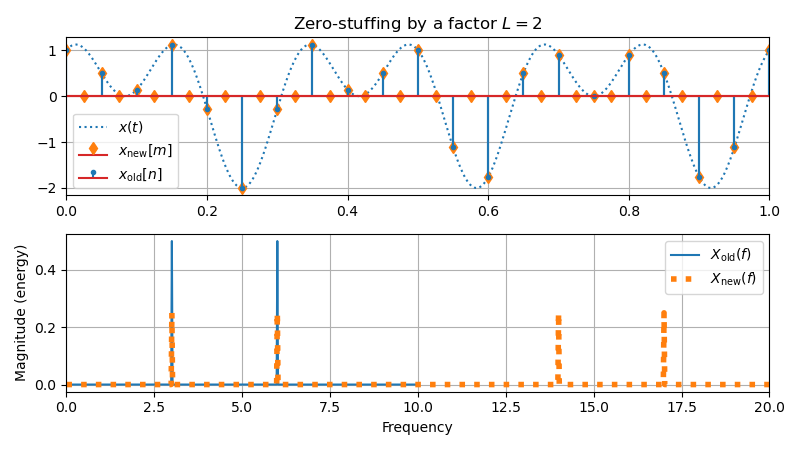

In [19]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
L = 2  # Upsampling Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before upsampling
t_m = np.linspace(0, T, fs*L*T, endpoint=False)  # Sample times after upsampling

x = lambda t: np.sin(np.pi*6*t) + np.cos(np.pi*12*t) # The continuous-time signal x(t)
x_n = x(t_n)  # Original sampled signal
x_m = interp(x_n, L)

plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim(xmax=1)
ax[0].legend()
ax[1].magnitude_spectrum(x_n, Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x_m, Fs=fs*L, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Zero-stuffing by a factor $L={L}$");

# Interpolation filtering

<img src="figures/sample_rate_conversion/upsampling.png" align="center" style="width: 60%; margin-left:100px">

* A "zero-stuffed" signal has one or more spectral images which need to be suppressed
* "Baseband" spectral content needs to be amplified by a factor $L$

## Example:

* Find a interpolation filter $h[n]$ which will perform [*linear interpolation*](https://en.wikipedia.org/wiki/Linear_interpolation) given a signal $x[m]$ which has been "zero-stuffed" with interpolation factor $L=2$

## Linear interpolation demo

Output()

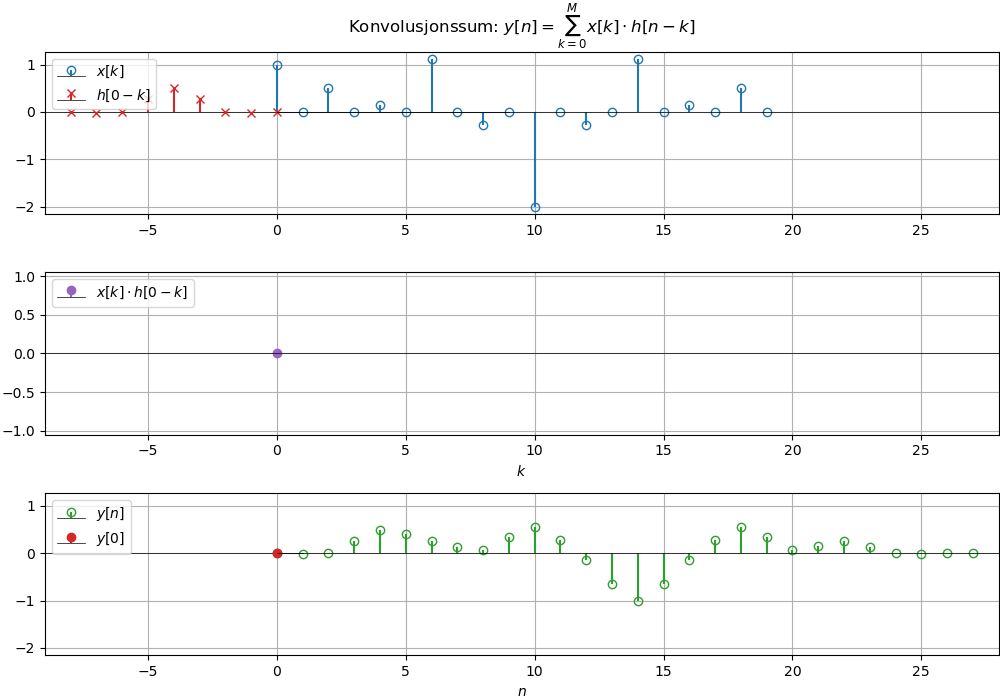

In [24]:
from demos import ConvolutionDemo
h_n = design_lowpass(9, 2)
ConvolutionDemo(interp(x_n[:10], 2), h_n, fig_num=2,figsize=(10,7));    

# Upsampling system

<img src="figures/sample_rate_conversion/upsampling.png" align="center" style="width: 60%; margin-left:100px">

* Process:
    * Increase sample rate using "zero stuffing"
    * Use a FIR filter to suppress spectral images
    * Amplify output to match magnitude of input

## Upsampling example

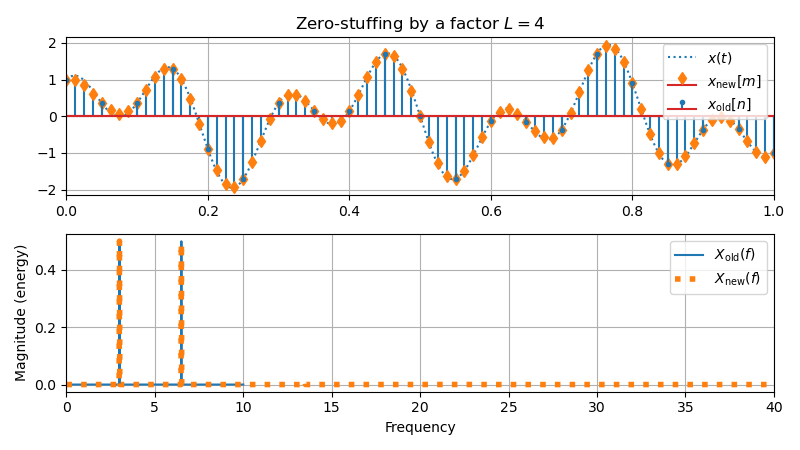

In [27]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
L = 4  # Upsampling Factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before upsampling
t_m = np.linspace(0, T, fs*L*T, endpoint=False)  # Sample times after upsampling

x = lambda t: np.sin(np.pi*6*t) + np.cos(np.pi*13*t) # The continuous-time signal x(t)

x_n = x(t_n)  # Original sampled signal
x_m = np.zeros(fs*L*T)  # Initialize to zeros
x_m[::L] = x_n  # x[m/L] = x[n], m%L==0 
h_n = design_lowpass(33, L)
x_m = np.convolve(x_m, h_n, mode="same")*L

plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim(xmax=1)
ax[0].legend()
ax[1].magnitude_spectrum(x_n, Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x_m, Fs=fs*L, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title(f"Zero-stuffing by a factor $L={L}$");

# Upsampling tricks

* If only $1$ in $L$ input samples is nonzero, the number of samples to process per sample in the interpolation filter is $\frac{\text{numtaps}}{L}$
    * *Polyphase filters* are specialized to take advantage of this

# Part III: *Resampling*

<img src="figures/sample_rate_conversion/resampling.png" align="center" style="width: 80%; margin-left:100px">
 
* Decimation filtering and interpolation filtering performed by one filter
    * Corner frequency: $\hat{\omega}_c = \min\left(\frac{\pi}{M}, \frac{\pi}{L}\right)$
* Limitation:
    * Resampling factor must be a rational number $\frac{f_{s, \text{ new}}}{f_{s, \text{ old}}} = \frac{L}{M}, \ \ L, M \in \mathbb{Z}$

## Resampling example

* Use python to resample a signal $x[n]$, increasing the sample rate by a factor of $1.5$

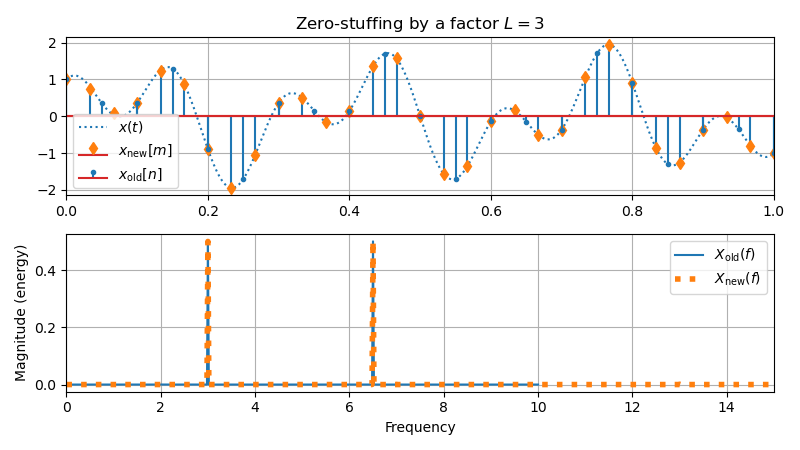

In [29]:
fs = 20  # Original Sampling Frequency
T = 100  # Signal duration
L = 3  # Interpolation Factor
M = 2  # Decimation factor

t = np.linspace(0, 1, 501)  # "Continuous-time" vector 
t_n = np.linspace(0, T, fs*T, endpoint=False)  # Sample times before upsampling
t_m = np.linspace(0, T, int(fs*L/M*T), endpoint=False)  # Sample times after upsampling

x = lambda t: np.sin(np.pi*6*t) + np.cos(np.pi*13*t) # The continuous-time signal x(t)

x_n = x(t_n)  # Original sampled signal
x_k = interp(x_n, L)
x_k = np.convolve(x_k, design_lowpass(33, 3)*L, mode="same")
x_m = decimate(x_k, M)

plt.close(2); 
fig, ax = plt.subplots(2,1, num=2)
ax[0].plot(t, x(t), ":", label="$x(t)$")
ax[0].stem(t_m, x_m, markerfmt="C1d", label="$x_{\\text{new}}[m]$")
ax[0].stem(t_n, x_n, markerfmt=".", label="$x_{\\text{old}}[n]$")
ax[0].set_xlim(xmax=1)
ax[0].legend()
ax[1].magnitude_spectrum(x_n, Fs=fs, label="$X_{\\text{old}}(f)$");
ax[1].magnitude_spectrum(x_m, Fs=fs*L/M, linestyle=":", linewidth=4, label="$X_{\\text{new}}(f)$");
ax[1].legend()
ax[0].set_title("Resampling by factor $\\frac{L}{M}=\\frac{%d}{%d}"%(L, M));

# Comments on resampling

* FIR filters preferred
    * Permits polyphase filtering
    * Linear phase
* Can be computationally intensive
    * Not ideal for oversampling at *very* high sampling rates

# CIC filters
[tavle]